In [2]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch
import cv2
import torch.nn as nn
import albumentations as A
import time
import copy

In [2]:
# Set the path to the dataset folder
dataset_path = "Cam101"

# Load the RGB values and class names from the label_colors.txt file
label_colors = {}
with open(os.path.join(dataset_path, "label_colors.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        values = line.strip().split()  
        rgb = tuple(map(int, values[:3]))  
        label = " ".join(values[3:])     
        label_colors[rgb] = label

In [3]:
# Function to load images and their labels
def load_data(data_path):
    images = []
    labels = []

    for file in os.listdir(data_path):
        if file.endswith(".png") and not file.endswith("_L.png"):  # Find images whose naming format is .png 
            img = cv2.imread(os.path.join(data_path, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the color space of the image from BGR to RGB
            label_img = cv2.imread(os.path.join(data_path, file[:-4] + "_L.png"))  # Read the corresponding label image whose naming format is _L.png
            label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)

            images.append(img)
            labels.append(label_img)

    return images, labels

In [4]:
train_data_path = os.path.join(dataset_path, "train")  # Load traindata path
test_data_path = os.path.join(dataset_path, "test")  # Load testdata path

train_images, train_labels = load_data(train_data_path)  # load training image and label
test_images, test_labels = load_data(test_data_path)  # load test image and label

print("Number of training images:", len(train_images))
print("Number of training labels:", len(train_labels))
print("Number of testing images:", len(test_images))
print("Number of testing labels:", len(test_labels))

Number of training images: 90
Number of training labels: 90
Number of testing images: 11
Number of testing labels: 11


In [5]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, augmentations=None, augmentations_multiplier=1):
        self.images = images
        self.labels = labels
        self.augmentations = augmentations
        self.augmentations_multiplier = augmentations_multiplier  # Through data augmentation, the multiple of data increase

    def __len__(self):
        return len(self.images)* self.augmentations_multiplier

    def __getitem__(self, idx):
        idx = idx % len(self.images)
    
        img = self.images[idx]  # Retrieve the image at the given index
        lbl = self.labels[idx]  # Retrieve the label (segmentation mask) at the given index

        if self.augmentations:
            augmented = self.augmentations(image=img, mask=lbl)  # Apply augmentation to image and label
            img = augmented['image']
            lbl = augmented['mask']

        img = np.transpose(img, (2, 0, 1)).astype(np.float32)  # Transpose, change channel position

        # Convert the label to a single-channel tensor
        lbl_single_channel = np.zeros(lbl.shape[:2], dtype=np.int64)
        for i, (r, g, b) in enumerate(label_colors.keys()):
            lbl_single_channel[(lbl == (r, g, b)).all(axis=2)] = i

        # Convert the data type of images and labels to Tensor
        img = torch.tensor(img) / 255.0  # Standardization
        lbl = torch.tensor(lbl_single_channel)

        return img, lbl

In [6]:
# Define the augmentation pipeline
train_augmentations = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RGBShift(p=0.5) ])

test_augmentations = A.Compose([A.Resize(256, 256)])

In [8]:
# Create the CustomDataset instances for training and testing
train_data = CustomDataset(train_images, train_labels, augmentations=train_augmentations, augmentations_multiplier=4)
test_data = CustomDataset(test_images, test_labels, augmentations=test_augmentations)

train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)


In [9]:
# Define FCN8s model
class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s, self).__init__()

        # VGG16-based feature extractor
        self.features = nn.Sequential(
            # First layers of the VGG16 model. Two 2D convolutional layers, each followed by a ReLU activation function, and a 2D max pooling layer.
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 1x1 convolutional layers. They used to convert the deep feature maps to the same number of channels as the number of classes.
        self.fcn32 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.fcn16 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.fcn8 = nn.Conv2d(256, num_classes, kernel_size=1)
        
        # Transposed convolutional layers. They used for upsampling the score maps to the original image size.
        self.up32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.up16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.up8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        # Get the output from different layers of the VGG16 model.
        pool3 = self.features[:17](x)
        pool4 = self.features[:24](x)
        pool5 = self.features(x)
        
        # Apply the 1x1 convolutional layers to the respective pooling layers to compute the score maps.
        fcn32 = self.fcn32(pool5)
        fcn16 = self.fcn16(pool4)
        fcn8 = self.fcn8(pool3)
        
        # Perform upsampling by the transposed convolutional layers.
        up32 = self.up32(fcn32)
        up16 = self.up16(fcn16 + up32)
        up8 = self.up8(fcn8 + up16)

        return up8

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 50

# Define pixel accuracy function
def pixel_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).float()
    return correct.sum().item() / (target.size(0) * target.size(1) * target.size(2))

# Define mean Intersection over Union (mIoU) function
def iou_score(output, target):
    _, predicted = torch.max(output, 1)
    intersection = (predicted & target).float().sum((1, 2))
    union = (predicted | target).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

In [11]:
# define train and validation function
def train_validation(model,optimizer,criterion):
    model = model.to(device)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_ious, valid_ious = [], []
    best_valid_iou, best_valid_acc = 0, 0
    best_model = None
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_acc, train_iou = 0, 0, 0
        num_batches = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += pixel_accuracy(outputs, labels)
            train_iou += iou_score(outputs, labels)
            num_batches += 1

        train_loss /= num_batches
        train_acc /= num_batches
        train_iou /= num_batches

        end_time = time.time()
        training_time = end_time - start_time

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"training time: {training_time:.2f} seconds")

        model.eval()
        valid_loss, valid_acc, valid_iou = 0, 0, 0
        num_batches = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                valid_acc += pixel_accuracy(outputs, labels)
                valid_iou += iou_score(outputs, labels)
                num_batches += 1

        valid_loss /= num_batches
        valid_acc /= num_batches
        valid_iou /= num_batches

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        train_ious.append(train_iou)
        valid_ious.append(valid_iou)

        print(f"Train Loss: {train_loss:.4f}, Train Pixel-wise Accuracy: {train_acc:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Pixel-wise Accuracy: {valid_acc:.4f}, Valid IoU: {valid_iou:.4f}")

        # Save the best model based on validation mIoU and Pixel-wise Accuracy
        if valid_iou > best_valid_iou and valid_acc > best_valid_acc:
            best_valid_iou = valid_iou
            best_valid_acc = valid_acc
            best_model = copy.deepcopy(model)
        
    return best_model, train_losses, valid_losses, train_accuracies, valid_accuracies, train_ious, valid_ious

In [12]:
# Define the function to display the Loss, Pixel-wise accuracy and IoU
def plot_evaluation_metrics_graph(train_losses, valid_losses, train_accuracies, valid_accuracies, train_ious, valid_ious):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label="Training Pixel-wise Accuracy")
    plt.plot(epochs, valid_accuracies, label="Validation Pixel-wise Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Pixel-wise Accuracy")
    plt.title("Pixel-wise Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_ious, label="Training IoU")
    plt.plot(epochs, valid_ious, label="Validation IoU")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title("IoU")
    plt.legend()

    plt.show()

Epoch 1/50:
training time: 32.83 seconds
Train Loss: 2.6882, Train Pixel-wise Accuracy: 0.2216, Train IoU: 0.3405
Valid Loss: 2.1507, Valid Pixel-wise Accuracy: 0.2504, Valid IoU: 0.2704
Epoch 2/50:
training time: 27.13 seconds
Train Loss: 2.1191, Train Pixel-wise Accuracy: 0.2578, Train IoU: 0.3667
Valid Loss: 2.0608, Valid Pixel-wise Accuracy: 0.2668, Valid IoU: 0.4644
Epoch 3/50:
training time: 26.60 seconds
Train Loss: 2.0739, Train Pixel-wise Accuracy: 0.2640, Train IoU: 0.4741
Valid Loss: 2.0371, Valid Pixel-wise Accuracy: 0.2645, Valid IoU: 0.4852
Epoch 4/50:
training time: 27.24 seconds
Train Loss: 2.0477, Train Pixel-wise Accuracy: 0.2649, Train IoU: 0.4946
Valid Loss: 2.0529, Valid Pixel-wise Accuracy: 0.2678, Valid IoU: 0.5047
Epoch 5/50:
training time: 26.88 seconds
Train Loss: 2.0296, Train Pixel-wise Accuracy: 0.2686, Train IoU: 0.5053
Valid Loss: 1.9982, Valid Pixel-wise Accuracy: 0.2719, Valid IoU: 0.5106
Epoch 6/50:
training time: 27.74 seconds
Train Loss: 1.9050, Trai

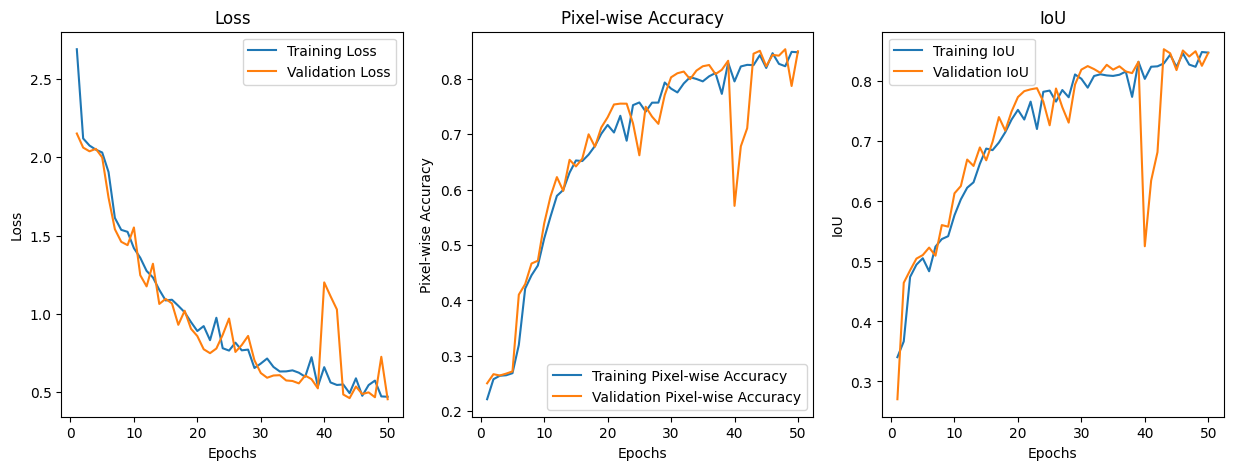

In [13]:
# For FCN8s model, explore different optimizer to find the best model
# Explore RMSprop optimizer
num_classes = len(label_colors)
fcn_model1 = FCN8s(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.RMSprop(fcn_model1.parameters(), lr=1e-4)
best_model1, train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(fcn_model1,optimizer1,criterion)
plot_evaluation_metrics_graph(train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1)

Epoch 1/50:
training time: 29.63 seconds
Train Loss: 2.8667, Train Pixel-wise Accuracy: 0.1647, Train IoU: 0.3619
Valid Loss: 2.2144, Valid Pixel-wise Accuracy: 0.2451, Valid IoU: 0.3227
Epoch 2/50:
training time: 29.18 seconds
Train Loss: 2.1379, Train Pixel-wise Accuracy: 0.2528, Train IoU: 0.3244
Valid Loss: 2.0765, Valid Pixel-wise Accuracy: 0.2584, Valid IoU: 0.4140
Epoch 3/50:
training time: 28.59 seconds
Train Loss: 2.0614, Train Pixel-wise Accuracy: 0.2648, Train IoU: 0.4766
Valid Loss: 2.0219, Valid Pixel-wise Accuracy: 0.2708, Valid IoU: 0.5083
Epoch 4/50:
training time: 28.34 seconds
Train Loss: 2.0096, Train Pixel-wise Accuracy: 0.2685, Train IoU: 0.5047
Valid Loss: 1.9817, Valid Pixel-wise Accuracy: 0.2623, Valid IoU: 0.5074
Epoch 5/50:
training time: 28.85 seconds
Train Loss: 1.9907, Train Pixel-wise Accuracy: 0.2691, Train IoU: 0.5062
Valid Loss: 1.9496, Valid Pixel-wise Accuracy: 0.2773, Valid IoU: 0.5151
Epoch 6/50:
training time: 28.83 seconds
Train Loss: 1.9385, Trai

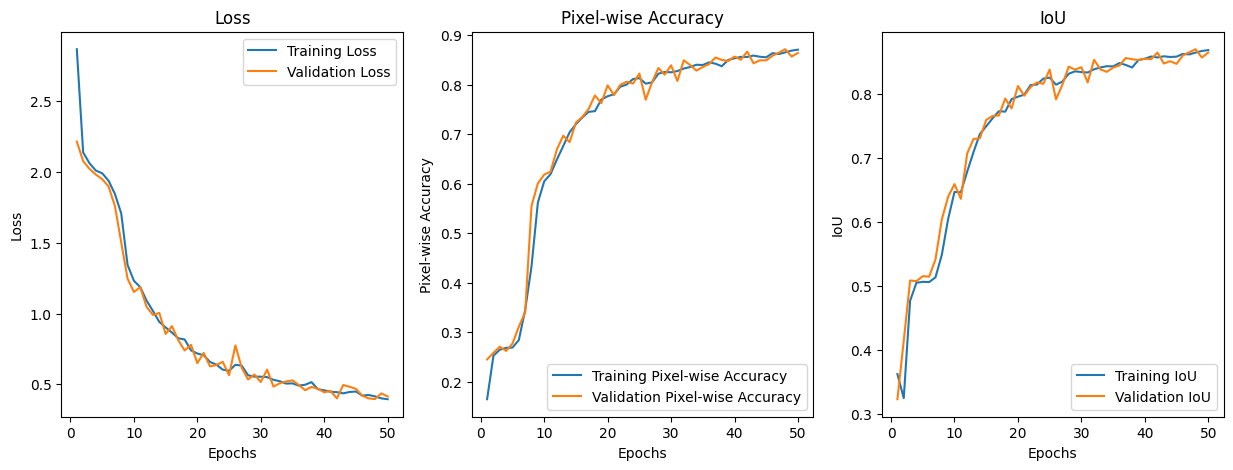

In [14]:
# Explore Adam optimizer 
num_classes = len(label_colors)
fcn_model2 = FCN8s(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(fcn_model2.parameters(), lr=1e-4)
best_model2, train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(fcn_model2,optimizer2, criterion)
plot_evaluation_metrics_graph(train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2)

In [15]:
# Compare the best validation mIoU and Pixel-wise Accuracy and select the best model
best_valid_iou1 = max(valid_ious1)
best_valid_iou2 = max(valid_ious2)
best_valid_acc1 = max(valid_accuracies1)
best_valid_acc2 = max(valid_accuracies2)

if best_valid_iou1 > best_valid_iou2 and best_valid_acc1 > best_valid_acc2:
    best_model = best_model1
else:
    best_model = best_model2

best_model = best_model.to(device)

In [16]:
# Define test progress
def test_model(model):
    model.eval()
    test_acc, test_iou = 0, 0
    num_batches = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)

            test_acc += pixel_accuracy(outputs, labels)
            test_iou += iou_score(outputs, labels)
            num_batches += 1

    test_acc /= num_batches
    test_iou /= num_batches

    return test_acc, test_iou

In [17]:
# Apply the best model to test progress
test_acc, test_iou = test_model(best_model)
print(f"Test Pixel-wise Accuracy: {test_acc:.4f}, Test Mean IoU: {test_iou:.4f}")

Test Pixel-wise Accuracy: 0.8888, Test Mean IoU: 0.8869


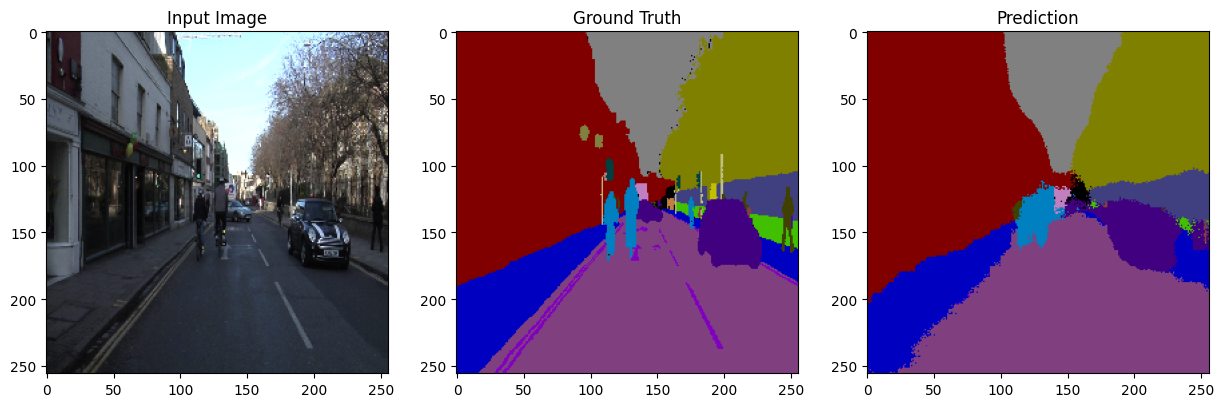

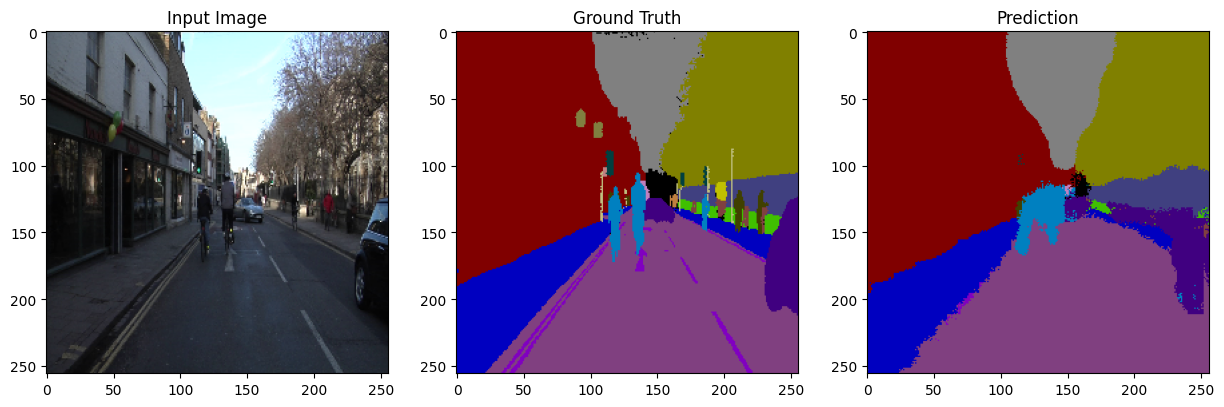

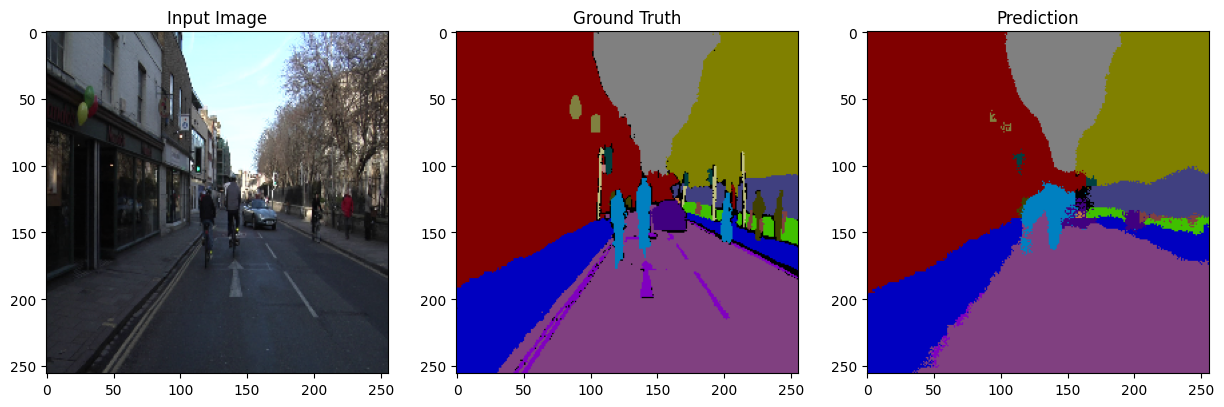

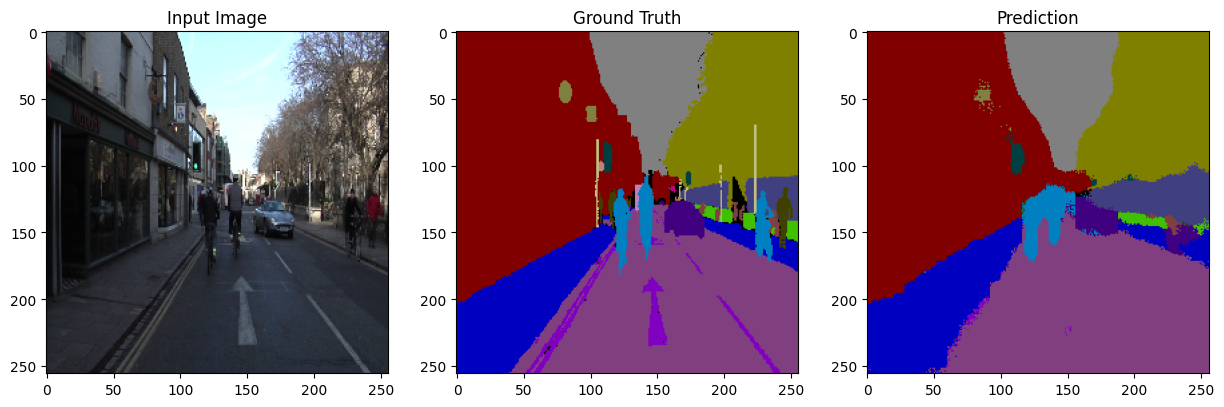

In [18]:
# Define the function to display input image, ground truth and prediction
def visualize_predictions(images, labels, predictions, num_images=4):
    # Create a dictionary to map class indices to RGB values
    index_colors = {idx: rgb for idx, (rgb, label) in enumerate(label_colors.items())}

    for i in range(num_images):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Input Image")

        label_rgb = np.zeros(tuple(labels[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            label_rgb[(labels[i].cpu().numpy() == idx)] = rgb
        ax[1].imshow(label_rgb)
        ax[1].set_title("Ground Truth")

        preds = torch.argmax(predictions, dim=1)
        pred_rgb = np.zeros(tuple(preds[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            pred_rgb[(preds[i].cpu().numpy() == idx)] = rgb
        ax[2].imshow(pred_rgb)
        ax[2].set_title("Prediction")

# Visualize the predictions on the test dataset
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)
    test_labels = test_labels.to(device).long()
    
    test_outputs = best_model(test_images)
    visualize_predictions(test_images, test_labels, test_outputs)

In [19]:
# Define the UNet model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Define a block in the U-Net which consists of two convolutional layers, each followed by a ReLU activation.
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Define an upsampling block in the U-Net which uses a transposed convolution
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Define the encoding blocks with increasing number of filters
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Pooling layer for downsampling the feature maps
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Middle layer between the encoding and decoding paths
        self.middle = conv_block(512, 1024)
        
        # Define the decoding blocks with decreasing number of filters, along with the upsampling blocks
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, out_channels)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))
        
        # Upsampling + skip connection from enc4 to dec4
        upconv4 = self.upconv4(middle)
        dec4 = self.dec4(torch.cat([upconv4, enc4], dim=1))

        # Upsampling + skip connection from enc3 to dec3
        upconv3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([upconv3, enc3], dim=1))

        # Upsampling + skip connection from enc2 to dec2
        upconv2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([upconv2, enc2], dim=1))

        # Upsampling + skip connection from enc1 to dec1
        upconv1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([upconv1, enc1], dim=1))

        return dec1

Epoch 1/50:
training time: 26.17 seconds
Train Loss: 3.1963, Train Pixel-wise Accuracy: 0.2060, Train IoU: 0.1844
Valid Loss: 2.7382, Valid Pixel-wise Accuracy: 0.2336, Valid IoU: 0.2727
Epoch 2/50:
training time: 26.71 seconds
Train Loss: 2.7176, Train Pixel-wise Accuracy: 0.2718, Train IoU: 0.2806
Valid Loss: 2.6280, Valid Pixel-wise Accuracy: 0.3213, Valid IoU: 0.2989
Epoch 3/50:
training time: 26.73 seconds
Train Loss: 2.5323, Train Pixel-wise Accuracy: 0.3068, Train IoU: 0.2517
Valid Loss: 2.1958, Valid Pixel-wise Accuracy: 0.3187, Valid IoU: 0.2291
Epoch 4/50:
training time: 26.95 seconds
Train Loss: 2.0492, Train Pixel-wise Accuracy: 0.3649, Train IoU: 0.3760
Valid Loss: 1.9436, Valid Pixel-wise Accuracy: 0.4011, Valid IoU: 0.4211
Epoch 5/50:
training time: 26.81 seconds
Train Loss: 1.9253, Train Pixel-wise Accuracy: 0.4257, Train IoU: 0.4701
Valid Loss: 1.8760, Valid Pixel-wise Accuracy: 0.4467, Valid IoU: 0.4785
Epoch 6/50:
training time: 26.48 seconds
Train Loss: 1.8772, Trai

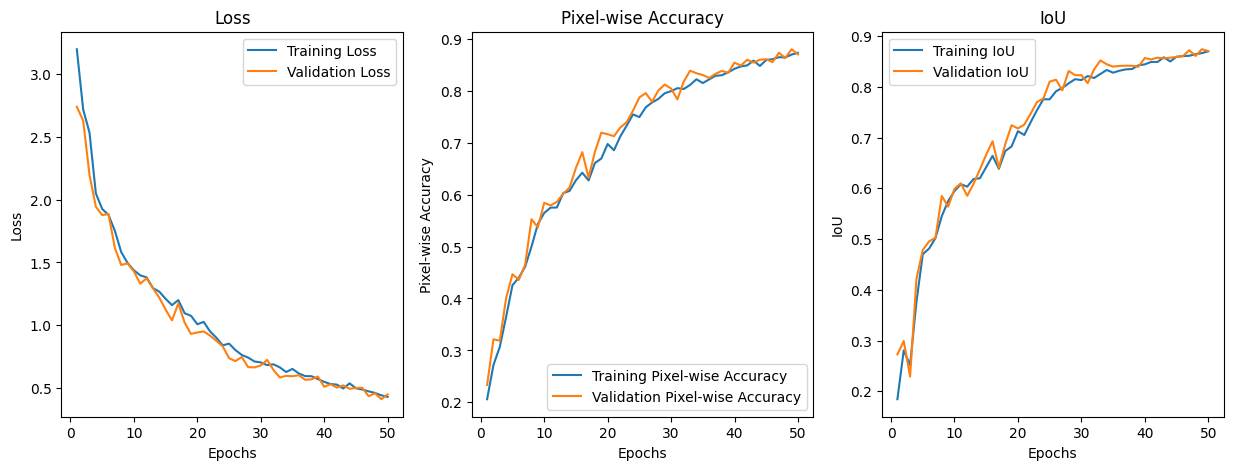

In [20]:
# For UNet model, explore different loss function to find the best model
# Explore Pixel-wise Cross Entropy
num_classes = len(label_colors)
unet_model1 = UNet(3, num_classes)
optimizer = torch.optim.Adam(unet_model1.parameters(), lr=1e-4)
criterion1 = nn.CrossEntropyLoss()
best_model1, train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(unet_model1,optimizer,criterion1)
plot_evaluation_metrics_graph(train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1)

In [21]:
# Define the function to calculate the weight of loss function
def calculate_weights(label_colors_count):
    class_weights = np.zeros(32).astype(float)
    total = sum(label_colors_count.values())
    median = np.median(list(label_colors_count.values()))
    for i in range(len(class_weights)):
        class_weights[i] = list(label_colors_count.values())[i] / median
    weight = torch.from_numpy(class_weights).float()
    weight = weight.to(device)
    return weight

# Count the number of pixels
label_colors_count = {(64, 128, 64): 0,
                    (192, 0, 128): 18984,
                    (0, 128, 192): 1392086,
                    (0, 128, 64): 0,
                    (128, 0, 0): 15203259,
                    (64, 0, 128): 903658,
                    (64, 0, 192): 8434,
                    (192, 128, 64): 55768,
                    (192, 192, 128): 355181,
                    (64, 64, 128): 1934631,
                    (128, 0, 192): 1053289,
                    (192, 0, 64): 1,
                    (128, 128, 64): 142331,
                    (192, 0, 192): 0,
                    (128, 64, 64): 453141,
                    (64, 192, 128): 0,
                    (64, 64, 0): 399089,
                    (128, 64, 128): 16953611,
                    (128, 128, 192): 0,
                    (0, 0, 192): 5395708,
                    (192, 128, 128): 43510,
                    (128, 128, 128): 5721501,
                    (64, 128, 192): 0,
                    (0, 0, 64): 0,
                    (0, 64, 64): 362160,
                    (192, 64, 128): 0,
                    (128, 128, 0): 10144738,
                    (192, 128, 192): 187768,
                    (64, 0, 64): 0,
                    (192, 192, 0): 69372,
                    (0, 0, 0): 534773,
                    (64, 192, 0): 875007}

weight = calculate_weights(label_colors_count)

Epoch 1/50:
training time: 25.95 seconds
Train Loss: 3.3348, Train Pixel-wise Accuracy: 0.1453, Train IoU: 0.4741
Valid Loss: 2.9010, Valid Pixel-wise Accuracy: 0.2326, Valid IoU: 0.4907
Epoch 2/50:
training time: 25.25 seconds
Train Loss: 2.3395, Train Pixel-wise Accuracy: 0.2627, Train IoU: 0.4596
Valid Loss: 1.4951, Valid Pixel-wise Accuracy: 0.2682, Valid IoU: 0.3689
Epoch 3/50:
training time: 24.94 seconds
Train Loss: 1.3529, Train Pixel-wise Accuracy: 0.2956, Train IoU: 0.4114
Valid Loss: 1.2467, Valid Pixel-wise Accuracy: 0.3337, Valid IoU: 0.4189
Epoch 4/50:
training time: 25.11 seconds
Train Loss: 1.1422, Train Pixel-wise Accuracy: 0.4028, Train IoU: 0.4565
Valid Loss: 1.0526, Valid Pixel-wise Accuracy: 0.4827, Valid IoU: 0.4971
Epoch 5/50:
training time: 24.78 seconds
Train Loss: 1.0290, Train Pixel-wise Accuracy: 0.4812, Train IoU: 0.4883
Valid Loss: 0.9405, Valid Pixel-wise Accuracy: 0.5239, Valid IoU: 0.5207
Epoch 6/50:
training time: 25.02 seconds
Train Loss: 0.9099, Trai

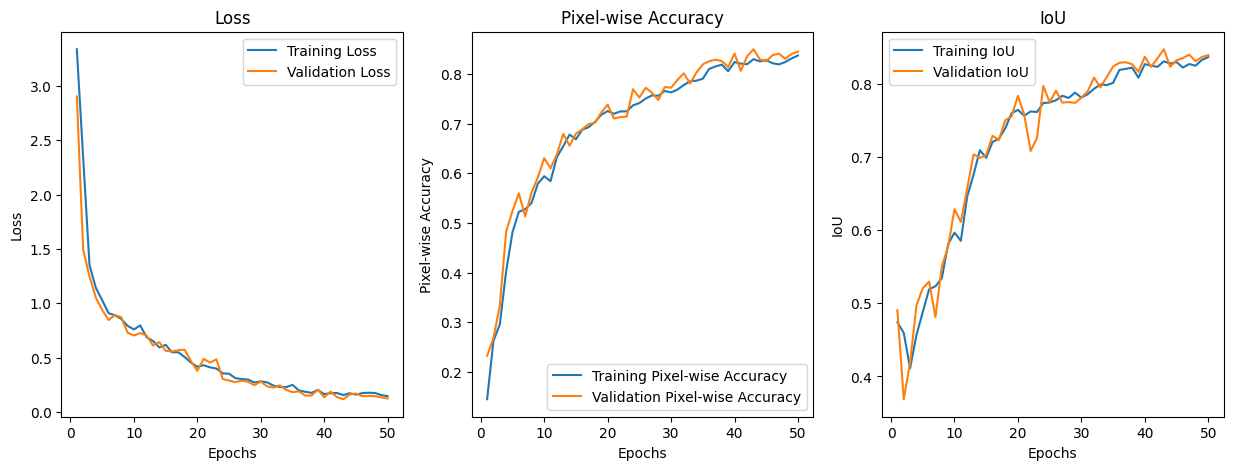

In [22]:
# Explore Weighted Pixel Cross Entropy
num_classes = len(label_colors)
unet_model2 = UNet(3, num_classes)
optimizer = torch.optim.Adam(unet_model2.parameters(), lr=1e-4)
criterion2 = nn.CrossEntropyLoss(weight)
best_model2, train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(unet_model2,optimizer,criterion2)
plot_evaluation_metrics_graph(train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2)

In [23]:
# Compare the best validation IoU and Pixel-wise Accuracy and select the best model
best_valid_iou1 = max(valid_ious1)
best_valid_iou2 = max(valid_ious2)
best_valid_acc1 = max(valid_accuracies1)
best_valid_acc2 = max(valid_accuracies2)

if best_valid_iou1 > best_valid_iou2 and best_valid_acc1 > best_valid_acc2:
    best_model = best_model1
else:
    best_model = best_model2

best_model = best_model.to(device)

In [24]:
# Apply the best model to test progress
test_acc, test_iou = test_model(best_model)
print(f"Test Pixel-wise Accuracy: {test_acc:.4f}, Test Mean IoU: {test_iou:.4f}")

Test Pixel-wise Accuracy: 0.8951, Test Mean IoU: 0.8883


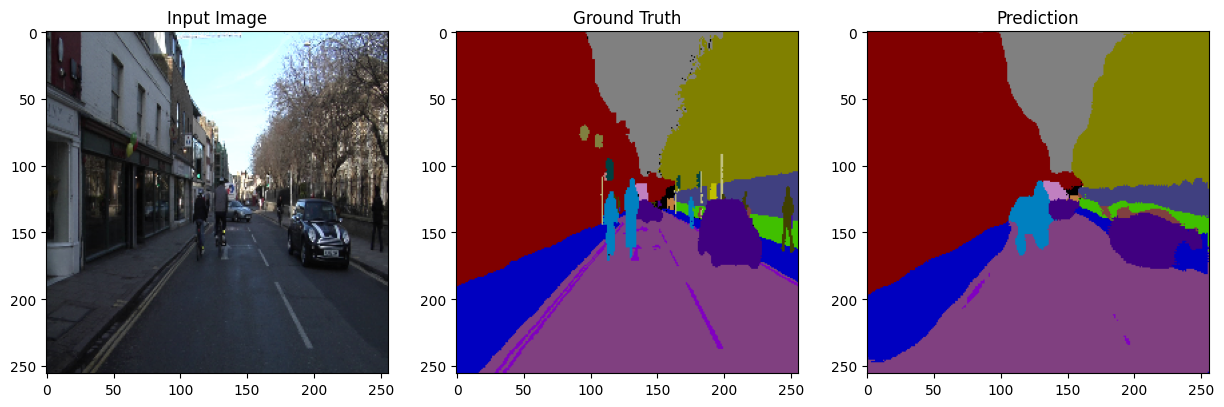

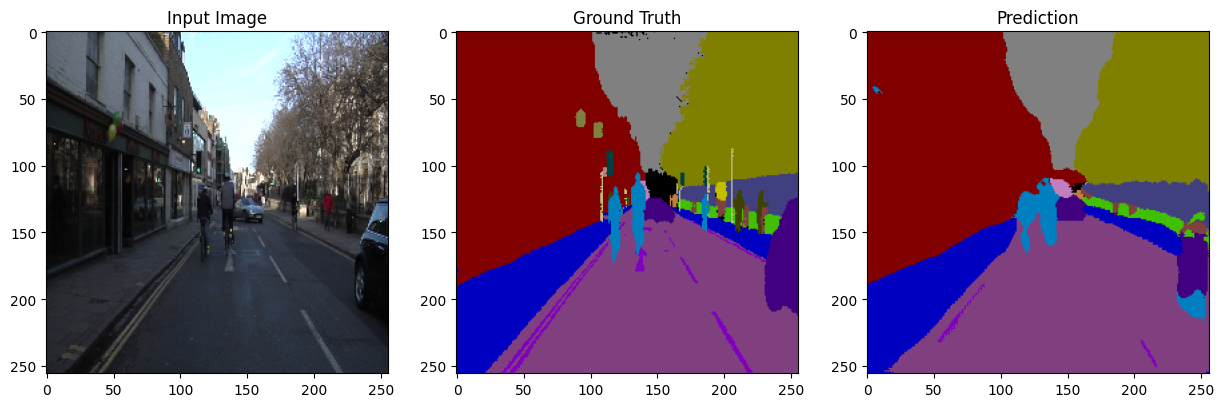

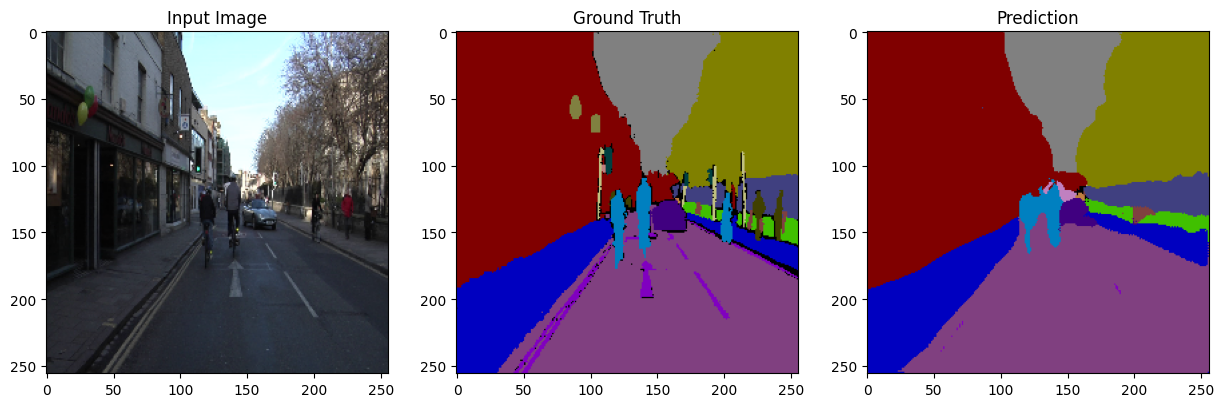

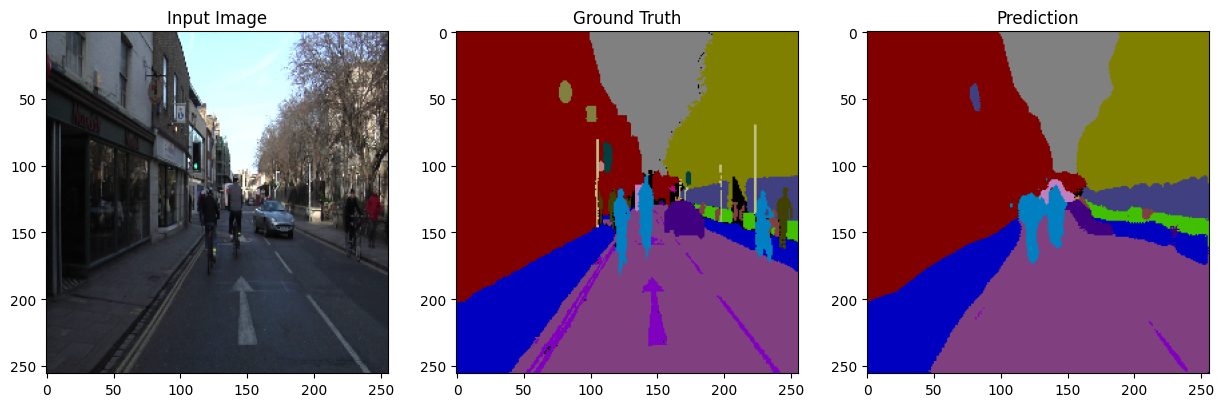

In [25]:
# Define the function to display input image, ground truth and prediction
def visualize_predictions(images, labels, predictions, num_images=4):
    # Create a dictionary to map class indices to RGB values
    index_colors = {idx: rgb for idx, (rgb, label) in enumerate(label_colors.items())}

    for i in range(num_images):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Input Image")

        label_rgb = np.zeros(tuple(labels[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            label_rgb[(labels[i].cpu().numpy() == idx)] = rgb
        ax[1].imshow(label_rgb)
        ax[1].set_title("Ground Truth")

        preds = torch.argmax(predictions, dim=1)
        pred_rgb = np.zeros(tuple(preds[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            pred_rgb[(preds[i].cpu().numpy() == idx)] = rgb
        ax[2].imshow(pred_rgb)
        ax[2].set_title("Prediction")

# Visualize the predictions on the test dataset
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)
    test_labels = test_labels.to(device).long()
    
    test_outputs = best_model(test_images)
    visualize_predictions(test_images, test_labels, test_outputs)

In [26]:
class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # Convolutional layer
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Another additional convolutional layer
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x):
        return self.layers(x)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        # The Atrous Spatial Pyramid Pooling (ASPP) module applies convolutional layers with different dilation rates, 
        # which allows it to effectively capture multi-scale context by aggregating multi-scale feature maps.
        self.module_list = []
        for rate in atrous_rates:
            self.module_list.append(
                nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False)
            )
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, x):
         # The forward function applies each ASPP module to the input and sums the results.
        return sum([module(x) for module in self.module_list])
    
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=32):
        super(DeepLabV3Plus, self).__init__()

        self.backbone = CustomBackbone()
        num_channels = 256  

        # The Atrous Spatial Pyramid Pooling (ASPP) module is added after the backbone. It uses different dilation rates 
        # to capture multi-scale context.
        self.aspp = ASPP(num_channels, num_channels, [1, 6, 12, 18])

        # The decoder of the network upsamples the low-resolution feature maps from the ASPP module to the original input size.
        # It first reduces the number of channels to one-fourth, applies a transposed convolution 
        # for upsampling, performs another convolution, and finally upsamples the feature map to the original size. 
        # The output layer is a 1x1 convolution that reduces the number of channels to the number of classes.
        self.decoder = nn.Sequential(
            nn.Conv2d(num_channels, num_channels // 4, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(num_channels // 4, num_channels // 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels // 4, num_channels // 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True),
            nn.Conv2d(num_channels // 4, num_classes, kernel_size=1),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.aspp(x)
        x = self.decoder(x)
        return x

Epoch 1/50:
training time: 20.30 seconds
Train Loss: 2.7027, Train Pixel-wise Accuracy: 0.2786, Train IoU: 0.5244
Valid Loss: 1.9896, Valid Pixel-wise Accuracy: 0.4369, Valid IoU: 0.4875
Epoch 2/50:
training time: 20.36 seconds
Train Loss: 1.4631, Train Pixel-wise Accuracy: 0.6143, Train IoU: 0.6530
Valid Loss: 1.2553, Valid Pixel-wise Accuracy: 0.6622, Valid IoU: 0.7220
Epoch 3/50:
training time: 19.57 seconds
Train Loss: 1.0814, Train Pixel-wise Accuracy: 0.6933, Train IoU: 0.7396
Valid Loss: 1.0796, Valid Pixel-wise Accuracy: 0.6862, Valid IoU: 0.7429
Epoch 4/50:
training time: 19.23 seconds
Train Loss: 0.9530, Train Pixel-wise Accuracy: 0.7121, Train IoU: 0.7594
Valid Loss: 0.9731, Valid Pixel-wise Accuracy: 0.7098, Valid IoU: 0.7609
Epoch 5/50:
training time: 19.50 seconds
Train Loss: 0.8961, Train Pixel-wise Accuracy: 0.7207, Train IoU: 0.7642
Valid Loss: 0.9385, Valid Pixel-wise Accuracy: 0.7134, Valid IoU: 0.7598
Epoch 6/50:
training time: 19.26 seconds
Train Loss: 0.8508, Trai

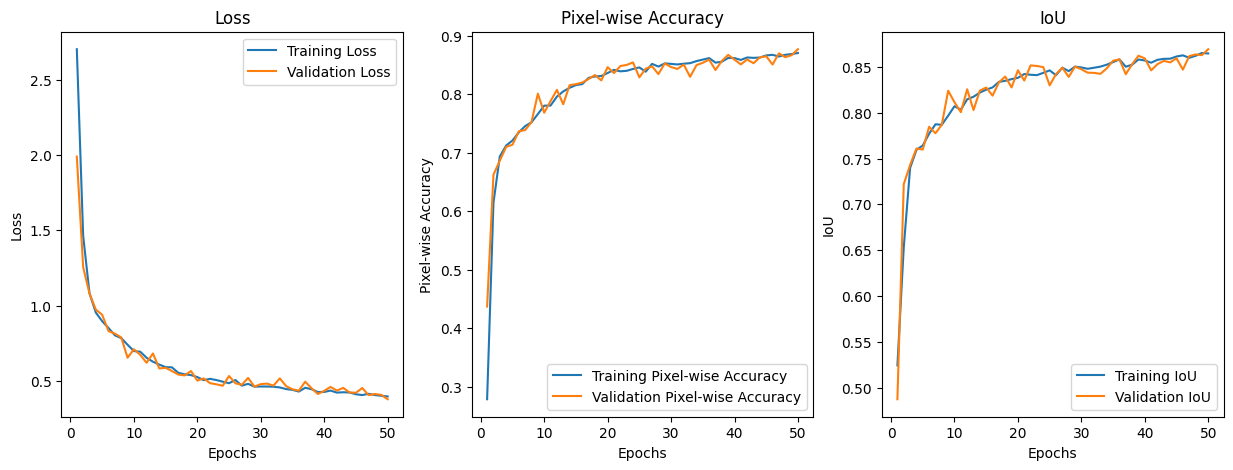

In [27]:
# For DeepLabV3+ model, explore different loss function to find the best model
# Explore Pixel-wise Cross Entropy
num_classes = len(label_colors)
dv3p_model1 = DeepLabV3Plus(num_classes)
optimizer = torch.optim.Adam(dv3p_model1.parameters(), lr=1e-4)
criterion1 = nn.CrossEntropyLoss()
best_model1, train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(dv3p_model1,optimizer,criterion1)
plot_evaluation_metrics_graph(train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1)

In [28]:
# define Dice Coefficient loss function
class DiceCoefficientLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceCoefficientLoss, self).__init__()
        self.smooth = smooth

    def forward(self, output, target):
        num_classes = output.shape[1]
        dice_loss = 0

        for i in range(num_classes):
            output_i = output[:, i]
            target_i = (target == i).float()
            
            intersection = (output_i * target_i).sum()
            dice_coeff = (2 * intersection + self.smooth) / (output_i.sum() + target_i.sum() + self.smooth)
            
            dice_loss += (1 - dice_coeff)
        
        return dice_loss / num_classes

Epoch 1/50:
training time: 21.08 seconds
Train Loss: 0.9967, Train Pixel-wise Accuracy: 0.0124, Train IoU: 0.1702
Valid Loss: 1.0024, Valid Pixel-wise Accuracy: 0.0100, Valid IoU: 0.1847
Epoch 2/50:
training time: 21.27 seconds
Train Loss: 0.9933, Train Pixel-wise Accuracy: 0.0225, Train IoU: 0.2298
Valid Loss: 0.9907, Valid Pixel-wise Accuracy: 0.0194, Valid IoU: 0.2146
Epoch 3/50:
training time: 21.52 seconds
Train Loss: 0.9857, Train Pixel-wise Accuracy: 0.0208, Train IoU: 0.2224
Valid Loss: 0.9834, Valid Pixel-wise Accuracy: 0.0111, Valid IoU: 0.2144
Epoch 4/50:
training time: 22.21 seconds
Train Loss: 0.9725, Train Pixel-wise Accuracy: 0.0156, Train IoU: 0.2848
Valid Loss: 0.9669, Valid Pixel-wise Accuracy: 0.0258, Valid IoU: 0.3528
Epoch 5/50:
training time: 21.95 seconds
Train Loss: 0.9623, Train Pixel-wise Accuracy: 0.0371, Train IoU: 0.3917
Valid Loss: 0.9583, Valid Pixel-wise Accuracy: 0.0476, Valid IoU: 0.4254
Epoch 6/50:
training time: 22.72 seconds
Train Loss: 0.9548, Trai

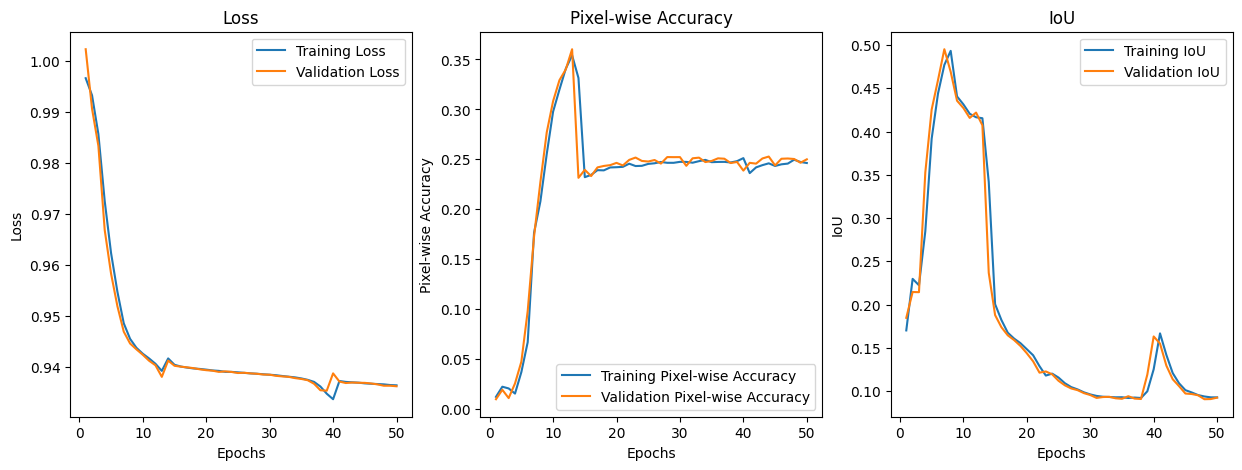

In [29]:
# Explore Dice Coefficient
num_classes = len(label_colors)
dv3p_model2 = DeepLabV3Plus(num_classes)
optimizer = torch.optim.Adam(dv3p_model2.parameters(), lr=1e-4)
criterion2 = DiceCoefficientLoss()
best_model2, train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(dv3p_model2,optimizer,criterion2)
plot_evaluation_metrics_graph(train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2)

In [30]:
# Compare the best validation IoU and Pixel-wise Accuracy and select the best model
best_valid_iou1 = max(valid_ious1)
best_valid_iou2 = max(valid_ious2)
best_valid_acc1 = max(valid_accuracies1)
best_valid_acc2 = max(valid_accuracies2)

if best_valid_iou1 > best_valid_iou2 and best_valid_acc1 > best_valid_acc2:
    best_model = best_model1
else:
    best_model = best_model2

best_model = best_model.to(device)

In [31]:
# Apply the best model to test progress
test_acc, test_iou = test_model(best_model)
print(f"Test Pixel-wise Accuracy: {test_acc:.4f}, Test Mean IoU: {test_iou:.4f}")

Test Pixel-wise Accuracy: 0.8885, Test Mean IoU: 0.8817


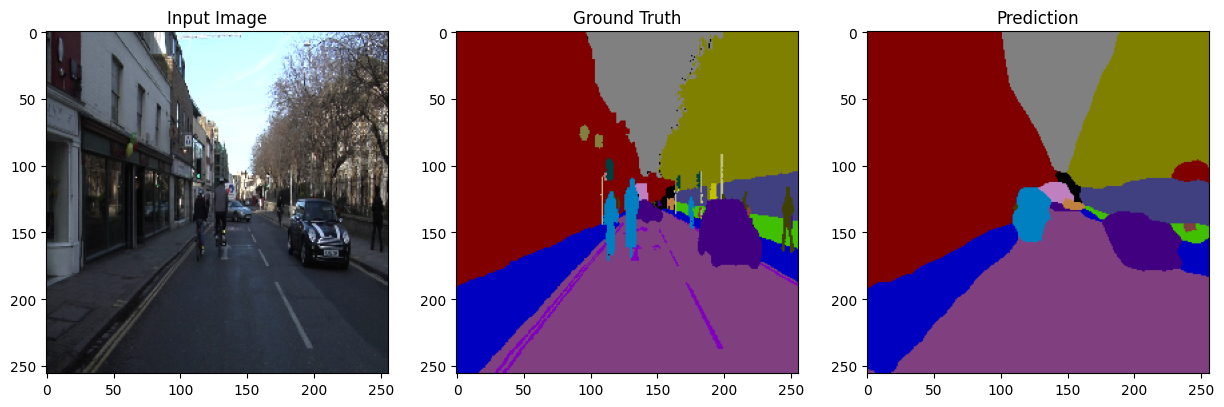

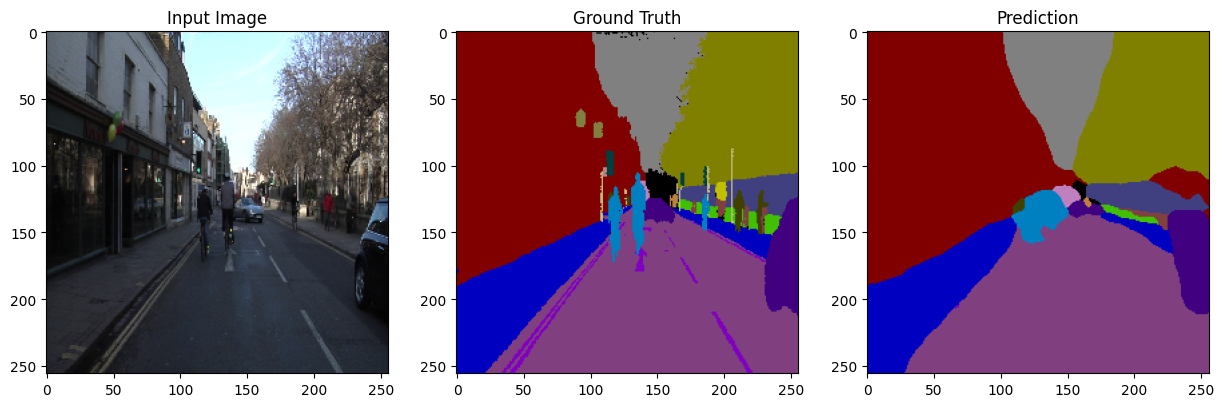

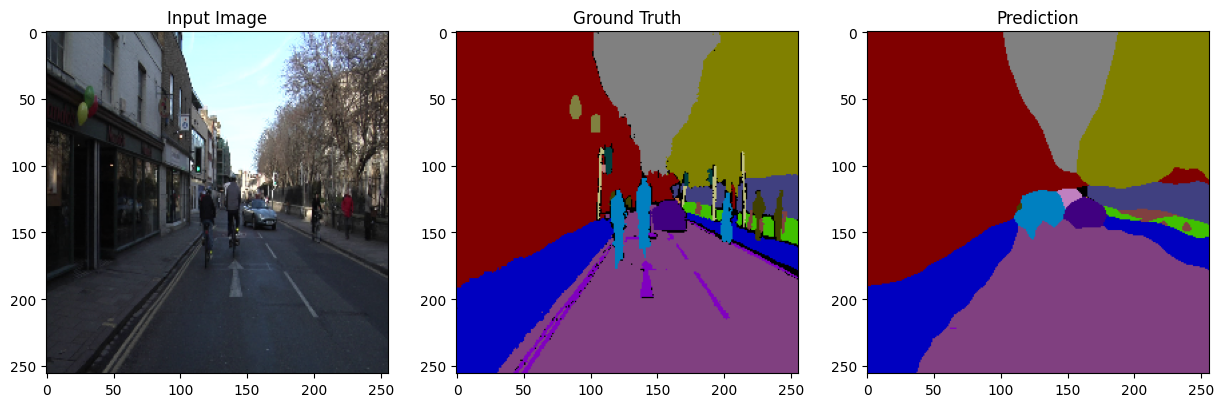

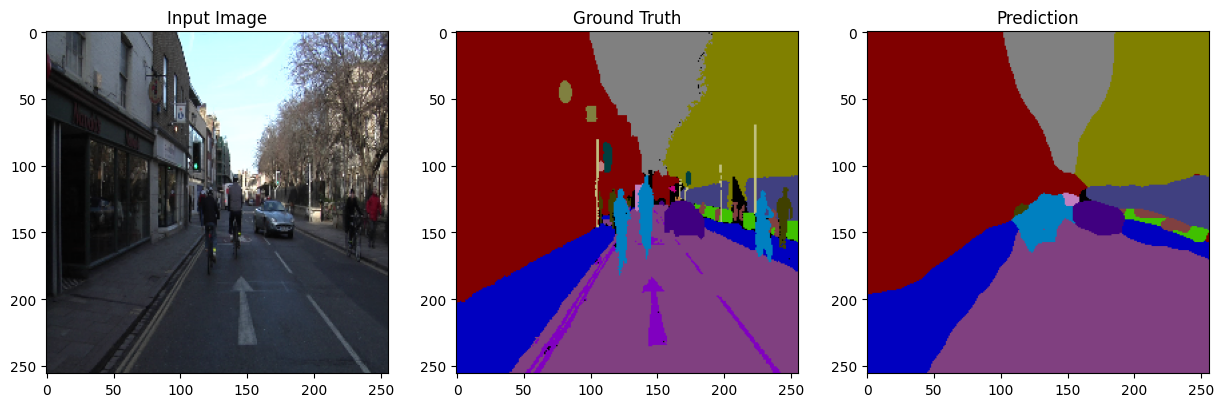

In [32]:
# Define the function to display input image, ground truth and prediction
def visualize_predictions(images, labels, predictions, num_images=4):
    # Create a dictionary to map class indices to RGB values
    index_colors = {idx: rgb for idx, (rgb, label) in enumerate(label_colors.items())}

    for i in range(num_images):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Input Image")

        label_rgb = np.zeros(tuple(labels[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            label_rgb[(labels[i].cpu().numpy() == idx)] = rgb
        ax[1].imshow(label_rgb)
        ax[1].set_title("Ground Truth")

        preds = torch.argmax(predictions, dim=1)
        pred_rgb = np.zeros(tuple(preds[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            pred_rgb[(preds[i].cpu().numpy() == idx)] = rgb
        ax[2].imshow(pred_rgb)
        ax[2].set_title("Prediction")

# Visualize the predictions on the test dataset
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)
    test_labels = test_labels.to(device).long()
    
    test_outputs = best_model(test_images)
    visualize_predictions(test_images, test_labels, test_outputs)